In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [2]:
df = pd.read_excel("data/MPVDatasetDownload.xlsx", sheet_name="2013-2020 Police Killings")

In [3]:
df.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,Unarmed/Did Not Have an Actual Weapon,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID
0,Pedro Martinez,66,Male,Hispanic,NaN,2020-11-18,NaN,Tyler,TX,NaN,...,Allegedly Armed,unknown weapon,other,not fleeing,no,6321.0,NaN,NaN,NaN,NaN
1,James Horton,42,Male,NaN,NaN,2020-11-17,NaN,Hart County,KY,NaN,...,Allegedly Armed,gun,attack,other,no,6322.0,NaN,NaN,NaN,NaN
2,Dustin James Acosta,28,Male,White,NaN,2020-11-17,NaN,St. Augustine,FL,NaN,...,Allegedly Armed,gun,attack,NaN,No,6320.0,NaN,NaN,NaN,NaN
3,Javon Brice,39,Male,NaN,NaN,2020-11-17,NaN,La Vergne,TN,NaN,...,Allegedly Armed,gun,attack,car,no,6319.0,NaN,NaN,NaN,NaN
4,Joshua D. Evans,32,Male,NaN,NaN,2020-11-16,NaN,Batesville,IN,NaN,...,Allegedly Armed,gun,attack,not fleeing,no,6314.0,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['Victim's name', 'Victim's age', 'Victim's gender', 'Victim's race',
       'URL of image of victim', 'Date of Incident (month/day/year)',
       'Street Address of Incident', 'City', 'State', 'Zipcode', 'County',
       'Agency responsible for death', 'ORI Agency Identifier (if available)',
       'Cause of death',
       'A brief description of the circumstances surrounding the death',
       'Official disposition of death (justified or other)',
       'Criminal Charges?',
       'Link to news article or photo of official document',
       'Symptoms of mental illness?', 'Unarmed/Did Not Have an Actual Weapon',
       'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)',
       'Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)',
       'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)',
       'Off-Duty Killing?',
       'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-co

In [5]:
df = df[["Victim's race", "Date of Incident (month/day/year)", "State"] ]

In [6]:
df.head()

,Victim's race,Date of Incident (month/day/year),State
0,Hispanic,2020-11-18,TX
1,NaN,2020-11-17,KY
2,White,2020-11-17,FL
3,NaN,2020-11-17,TN
4,NaN,2020-11-16,IN


In [7]:
df.columns = ["race", "date", "state"]

In [8]:
df["race"] = df.race.apply(lambda x: "Unknown" if x == "Unknown race" or x == "Unknown Race" or x == "unknown race" else x).iloc[:]

In [9]:
df.fillna("Unknown", inplace=True)

In [10]:
#df = df[(df["race"] == "White") | (df["race"] == "Black") | (df["race"] == "Hispanic")].reset_index(drop = True).iloc[:]

In [11]:
df.head(10)

,race,date,state
0,Hispanic,2020-11-18,TX
1,Unknown,2020-11-17,KY
2,White,2020-11-17,FL
3,Unknown,2020-11-17,TN
4,Unknown,2020-11-16,IN
5,Unknown,2020-11-16,FL
6,Unknown,2020-11-15,TX
7,White,2020-11-14,NH
8,Hispanic,2020-11-14,CA
9,Unknown,2020-11-14,TX


In [12]:
df.race.value_counts()

White               3769
Black               2158
Hispanic            1482
Unknown              922
Asian                132
Native American      120
Pacific Islander      46
Name: race, dtype: int64

## Total

In [13]:
def get_week(df, event):
    filtered = df[(df["date"] <= event)]
    return filtered.iloc[-1]["date"], filtered.index[-1]

In [14]:
def get_next_weeks(df, event, weeks):
    pos = get_week(df, event)[1]
    if pos + weeks + 1 > len(df):
        return df.iloc[pos:].total_victims.mean()
    else:
        return df.iloc[pos + 1: pos + weeks + 1].total_victims.mean()

In [15]:
def get_previous_weeks(df, event, weeks):
    pos = get_week(df, event)[1]
    if pos - weeks < 0:
        return df.iloc[:pos].total_victims.mean()
    else:
        return df.iloc[pos - weeks:pos].total_victims.mean()

In [16]:
def do_plot(df, events, minority):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    
    df["date_ordinal"]=df.date.apply(lambda date: date.toordinal())
    for i, event in enumerate(events):
        d = datetime.datetime.strptime(event, '%Y-%m-%d').date()
        if i == 0:
            df_before = df[df["date"]<=event]
        elif i == len(events) - 1:
            df_before = df[(df["date"]>=events[i - 1]) & (df["date"]<=event)]
            df_after = df[df["date"]>event]
        else:
            df_before = df[(df["date"]>=events[i - 1]) & (df["date"]<=event)]
        sns.regplot(x=df_before.date_ordinal,y=df_before.total_victims,data=df_before, fit_reg=True,scatter=False, color='black')
    
        ax.axvline(x=d.toordinal(), color = "red")
    sns.regplot(x=df_after.date_ordinal,y=df_after.total_victims,data=df_after, fit_reg=True,scatter=False, color='black')
    sns.lineplot(x=df.date_ordinal, y = df.total_victims, data = df)



    xticks = ax.get_xticks()
    xticks_dates = [datetime.date.fromordinal(int(x)).strftime('%Y-%m-%d') for x in xticks]
    ax.set_xticklabels(xticks_dates)
    
    if minority:
        ax.set_ylabel(f"Total {minority} victims")
    else:
        ax.set_ylabel("Total victims")

    plt.show()

In [17]:
def blm_march_influence(df, year, events, weeks, minority = None):
    
    df = df[(df["date"] >= f"{year}-01-01") & (df["date"] <= f"{year}-12-31")].reset_index(drop = True).iloc[:]
    
    if minority:
        df = df[df["race"] == minority].reset_index(drop = True)
    
    grouped = df.groupby("date")
    killings = {}

    for date in set(df["date"]):
        killings[date] = grouped.get_group(date).size / 3
    
    df = pd.DataFrame(killings.items(), columns = ["date", "total_victims"])
    pd.Grouper(key = "date", freq = "1W")
    df = df.groupby(pd.Grouper(key = "date", freq = "1W",)).sum().reset_index()
    
    
    do_plot(df, events, minority)
    
    for event in events:
        print(f"Average number of deaths over the previous {weeks} weeks before the event of {event} :" , get_previous_weeks(df, event, weeks))
        print(f"Average number of deaths over the next {weeks} weeks after the event of {event}:" , get_next_weeks(df, event, weeks))
        print()
    return df

In [18]:
g_floyd = "2020-05-25"
b_taylor = "2020-03-13"
biggest = "2020-06-06"

events = ["2013-11-02", "2014-07-17", "2014-08-09", "2015-04-12", "2015-11-16", "2015-11-24", "2016-07-05", b_taylor, g_floyd]

/Users/gfotiadis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


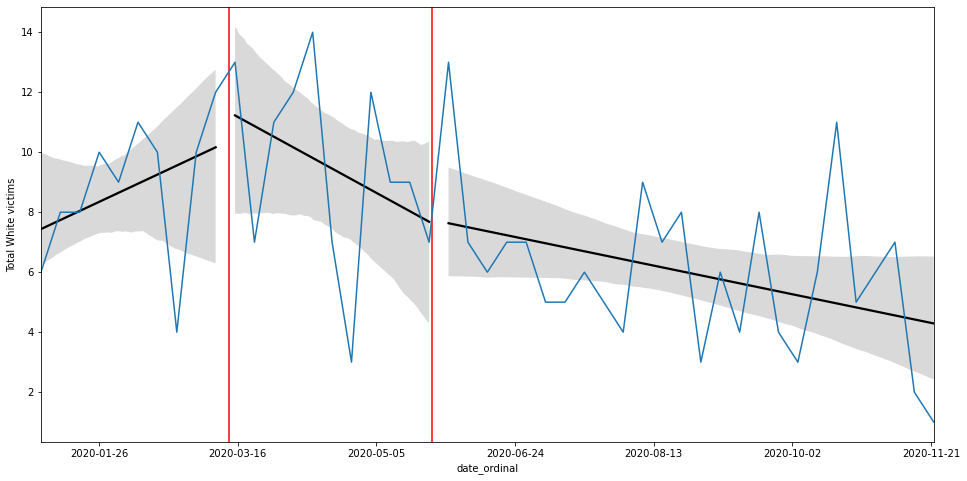

Average number of deaths over the previous 5 weeks before the event of 2020-03-13 : 8.8
Average number of deaths over the next 5 weeks after the event of 2020-03-13: 11.4

Average number of deaths over the previous 5 weeks before the event of 2020-05-25 : 8.0
Average number of deaths over the next 5 weeks after the event of 2020-05-25: 8.0



In [19]:
df_events = blm_march_influence(df, "2020", events[7:], 5, minority="White")

## Per state

In [ ]:
df.head()

In [ ]:
per_state = {}
grouped = df.groupby(["state", "date"])
for (state, date) in grouped.groups.keys():
        per_state[(state, date)] = (grouped.get_group((state, date)).size / 3)#, grouped.get_group((state, date))["race"])

In [ ]:
per_state = pd.DataFrame(per_state.items(), columns = ["state", "victims"])

In [ ]:
per_state["date"] = per_state["state"].apply(lambda x : x[1]).iloc[:]

In [ ]:
per_state["state"] = per_state["state"].apply(lambda x : x[0]).iloc[:]

In [ ]:
per_state

In [ ]:
texas = per_state.groupby("state").get_group("TX")

In [ ]:
ela = -1
for state in set(per_state["state"]):
    v = per_state.groupby("state").get_group(state)
    print(len(v), state)

In [ ]:
texas.plot(x = "date", y = "victims")

In [ ]:
df_total_deaths.sort_values("date")

In [ ]:
by_week = df_total_deaths.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).first()

In [ ]:
by_week = by_week.reset_index()

In [ ]:
by_week[by_week["date"] < "2013-12-31"].plot(x = "date", y = "total_victims")

In [ ]:
by_month = df_total_deaths.groupby(pd.Grouper(key = "date", freq = "1M", origin = "2013-01-01")).first()

In [ ]:
by_month.reset_index(inplace=True)

In [ ]:
by_month.plot(x = "date", y = "total_victims")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
by_week[(by_week["date"] > "2013-12-31") & (by_week["date"] <= "2014-12-31")].plot(x = "date", y = "total_victims",ax = ax)
ax.axvline(x="2014-07-17", color = "red")

In [ ]:
texas_per_week = texas.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).sum().reset_index()

In [ ]:
texas_per_week.reset_index(inplace=True)

In [ ]:
texas_per_week

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
texas_per_week[(texas_per_week["date"] > "2013-12-31") & (texas_per_week["date"] <= "2014-12-31")].plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2014-07-17", color = "red")

In [ ]:
mn = per_state.groupby("state").get_group("MN")
mn_per_week = mn.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).sum().reset_index()
mn_per_week.reset_index(inplace=True)

In [ ]:
mn[(mn["date"] > "2014-12-31") & (mn["date"] <= "2015-12-31")]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
mn_per_week[(mn_per_week["date"] > "2014-12-31") & (mn_per_week["date"] <= "2015-12-31")].plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2015-11-15", color = "red")

In [ ]:
mn

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
mn.plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2015-11-15", color = "red")